In [ ]:
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras import optimizers
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

169009152/169001437 [==============================] - 6s 0us/step


In [ ]:
def normalize(x):
  mean = np.mean(x, axis = (0, 1, 2, 3))
  std = np.std(x, axis = (0, 1, 2, 3))
  print(mean)
  print(std)
  x = (x - mean) / std
  return x

x_train = normalize(x_train)
x_test = normalize(x_test)

121.93584
68.38902
122.241035
68.63058


In [ ]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

y_train1 = keras.utils.to_categorical(y_train, 100)
y_test1 = keras.utils.to_categorical(y_test, 100)
y_val1 = keras.utils.to_categorical(y_val, 100)

In [ ]:
# Ref: https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/
# Ref: https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202
def inception_layer1(layer_in, filters):
	# 2 3x3 conv
	conv3_3 = Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_in)
	conv3_3 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu')(conv3_3)
	conv3_3 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu')(conv3_3)
 
	# 3x3 conv
	conv3 = Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_in)
	conv3 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu')(conv3)
 
	# 3x3 max pooling
	pool = MaxPool2D((3, 3), strides = (1, 1), padding = 'same')(layer_in)
	pool = Conv2D(filters = 256, kernel_size = (1, 1), padding = 'same', activation = 'relu')(pool)
  
  # 1x1 conv
	conv1 = Conv2D(filters = 256, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_in)
 
	# concatenate filters
	layer_out = concatenate([conv3_3, conv3, pool, conv1], axis = -1)
	return layer_out

# In this the filters are made deeper
def inception_layer2(layer_in, filters):
	# 2 3x3 conv changed to 2 (1x3 and 3x1)
	conv3_3 = Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_in)
	conv3_3 = Conv2D(filters = 256, kernel_size = (1, 3), padding = 'same', activation = 'relu')(conv3_3)
	conv3_3 = Conv2D(filters = 256, kernel_size = (3, 1), padding = 'same', activation = 'relu')(conv3_3)
	conv3_3 = Conv2D(filters = 256, kernel_size = (1, 3), padding = 'same', activation = 'relu')(conv3_3)
	conv3_3 = Conv2D(filters = 256, kernel_size = (3, 1), padding = 'same', activation = 'relu')(conv3_3)
 
	# 3x3 conv changed to (1x3 and 3x1)
	conv3 = Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_in)
	conv3 = Conv2D(filters = 256, kernel_size = (1, 3), padding = 'same', activation = 'relu')(conv3)
	conv3 = Conv2D(filters = 256, kernel_size = (3, 1), padding = 'same', activation = 'relu')(conv3)
 
	# 3x3 max pooling
	pool = MaxPool2D((3, 3), strides = (1, 1), padding = 'same')(layer_in)
	pool = Conv2D(filters = 256, kernel_size = (1, 1), padding = 'same', activation = 'relu')(pool)
  
  # 1x1 conv
	conv1 = Conv2D(filters = 256, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_in)
 
	# concatenate filters
	layer_out = concatenate([conv3_3, conv3, pool, conv1], axis = -1)
	return layer_out

# In this the filters are made wider not deeper
def inception_layer3(layer_in, filters):
	# 2 3x3 conv changed to 1 3x3 and 1 (1x3 and 3x1)
	conv3_3 = Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_in)
	conv3_3 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu')(conv3_3)
	conv3_3_1 = Conv2D(filters = 256, kernel_size = (1, 3), padding = 'same', activation = 'relu')(conv3_3)
	conv3_3_2 = Conv2D(filters = 256, kernel_size = (3, 1), padding = 'same', activation = 'relu')(conv3_3)
 
	# 3x3 conv changed to (1x3 and 3x1)
	conv3 = Conv2D(filters = 128, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_in)
	conv3_1 = Conv2D(filters = 256, kernel_size = (1, 3), padding = 'same', activation = 'relu')(conv3)
	conv3_2 = Conv2D(filters = 256, kernel_size = (3, 1), padding = 'same', activation = 'relu')(conv3)
 
	# 3x3 max pooling
	pool = MaxPool2D((3, 3), strides = (1, 1), padding = 'same')(layer_in)
	pool = Conv2D(filters = 256, kernel_size = (1, 1), padding = 'same', activation = 'relu')(pool)
  
  # 1x1 conv
	conv1 = Conv2D(filters = 256, kernel_size = (1, 1), padding = 'same', activation = 'relu')(layer_in)
 
	# concatenate filters
	layer_out = concatenate([conv3_3_1, conv3_3_2, conv3_1, conv3_2, pool, conv1], axis = -1)
	return layer_out


input = Input(shape = (32, 32, 3))
conv1 = Conv2D(filters = 64, kernel_size = (3, 3), strides = (2, 2), padding = "same", activation = "relu", kernel_initializer = 'he_normal')(input)
conv1 = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = 'he_normal')(conv1)
conv1 = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = 'he_normal')(conv1)

pool = MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(conv1)

conv2 = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = 'he_normal')(pool)
conv2 = Conv2D(filters = 256, kernel_size = (3, 3), strides = (2, 2), padding = "same", activation = "relu", kernel_initializer = 'he_normal')(conv2)
conv2 = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = 'he_normal')(conv2)

inception1 = conv2
for i in range(3):
  inception1 = inception_layer1(inception1, [])

inception2 = inception1
for i in range(5):
  inception2 = inception_layer2(inception2, [])

inception3 = inception2
for i in range(2):
  inception3 = inception_layer3(inception3, [])

pool2 = AveragePooling2D(pool_size = (3, 3), strides = (1, 1))(inception3)
flatten = Flatten()(pool2)
dense = Dense(units = 100, kernel_initializer = "he_normal", activation = "softmax")(flatten)

model = Model(inputs = input, outputs = dense)

In [ ]:
opt = optimizers.Adam(learning_rate = 0.0005)
model.compile(optimizer = opt, loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  73856       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 256)  295168      conv2d_1[0][0]                   
_______________________________________________________________________________________

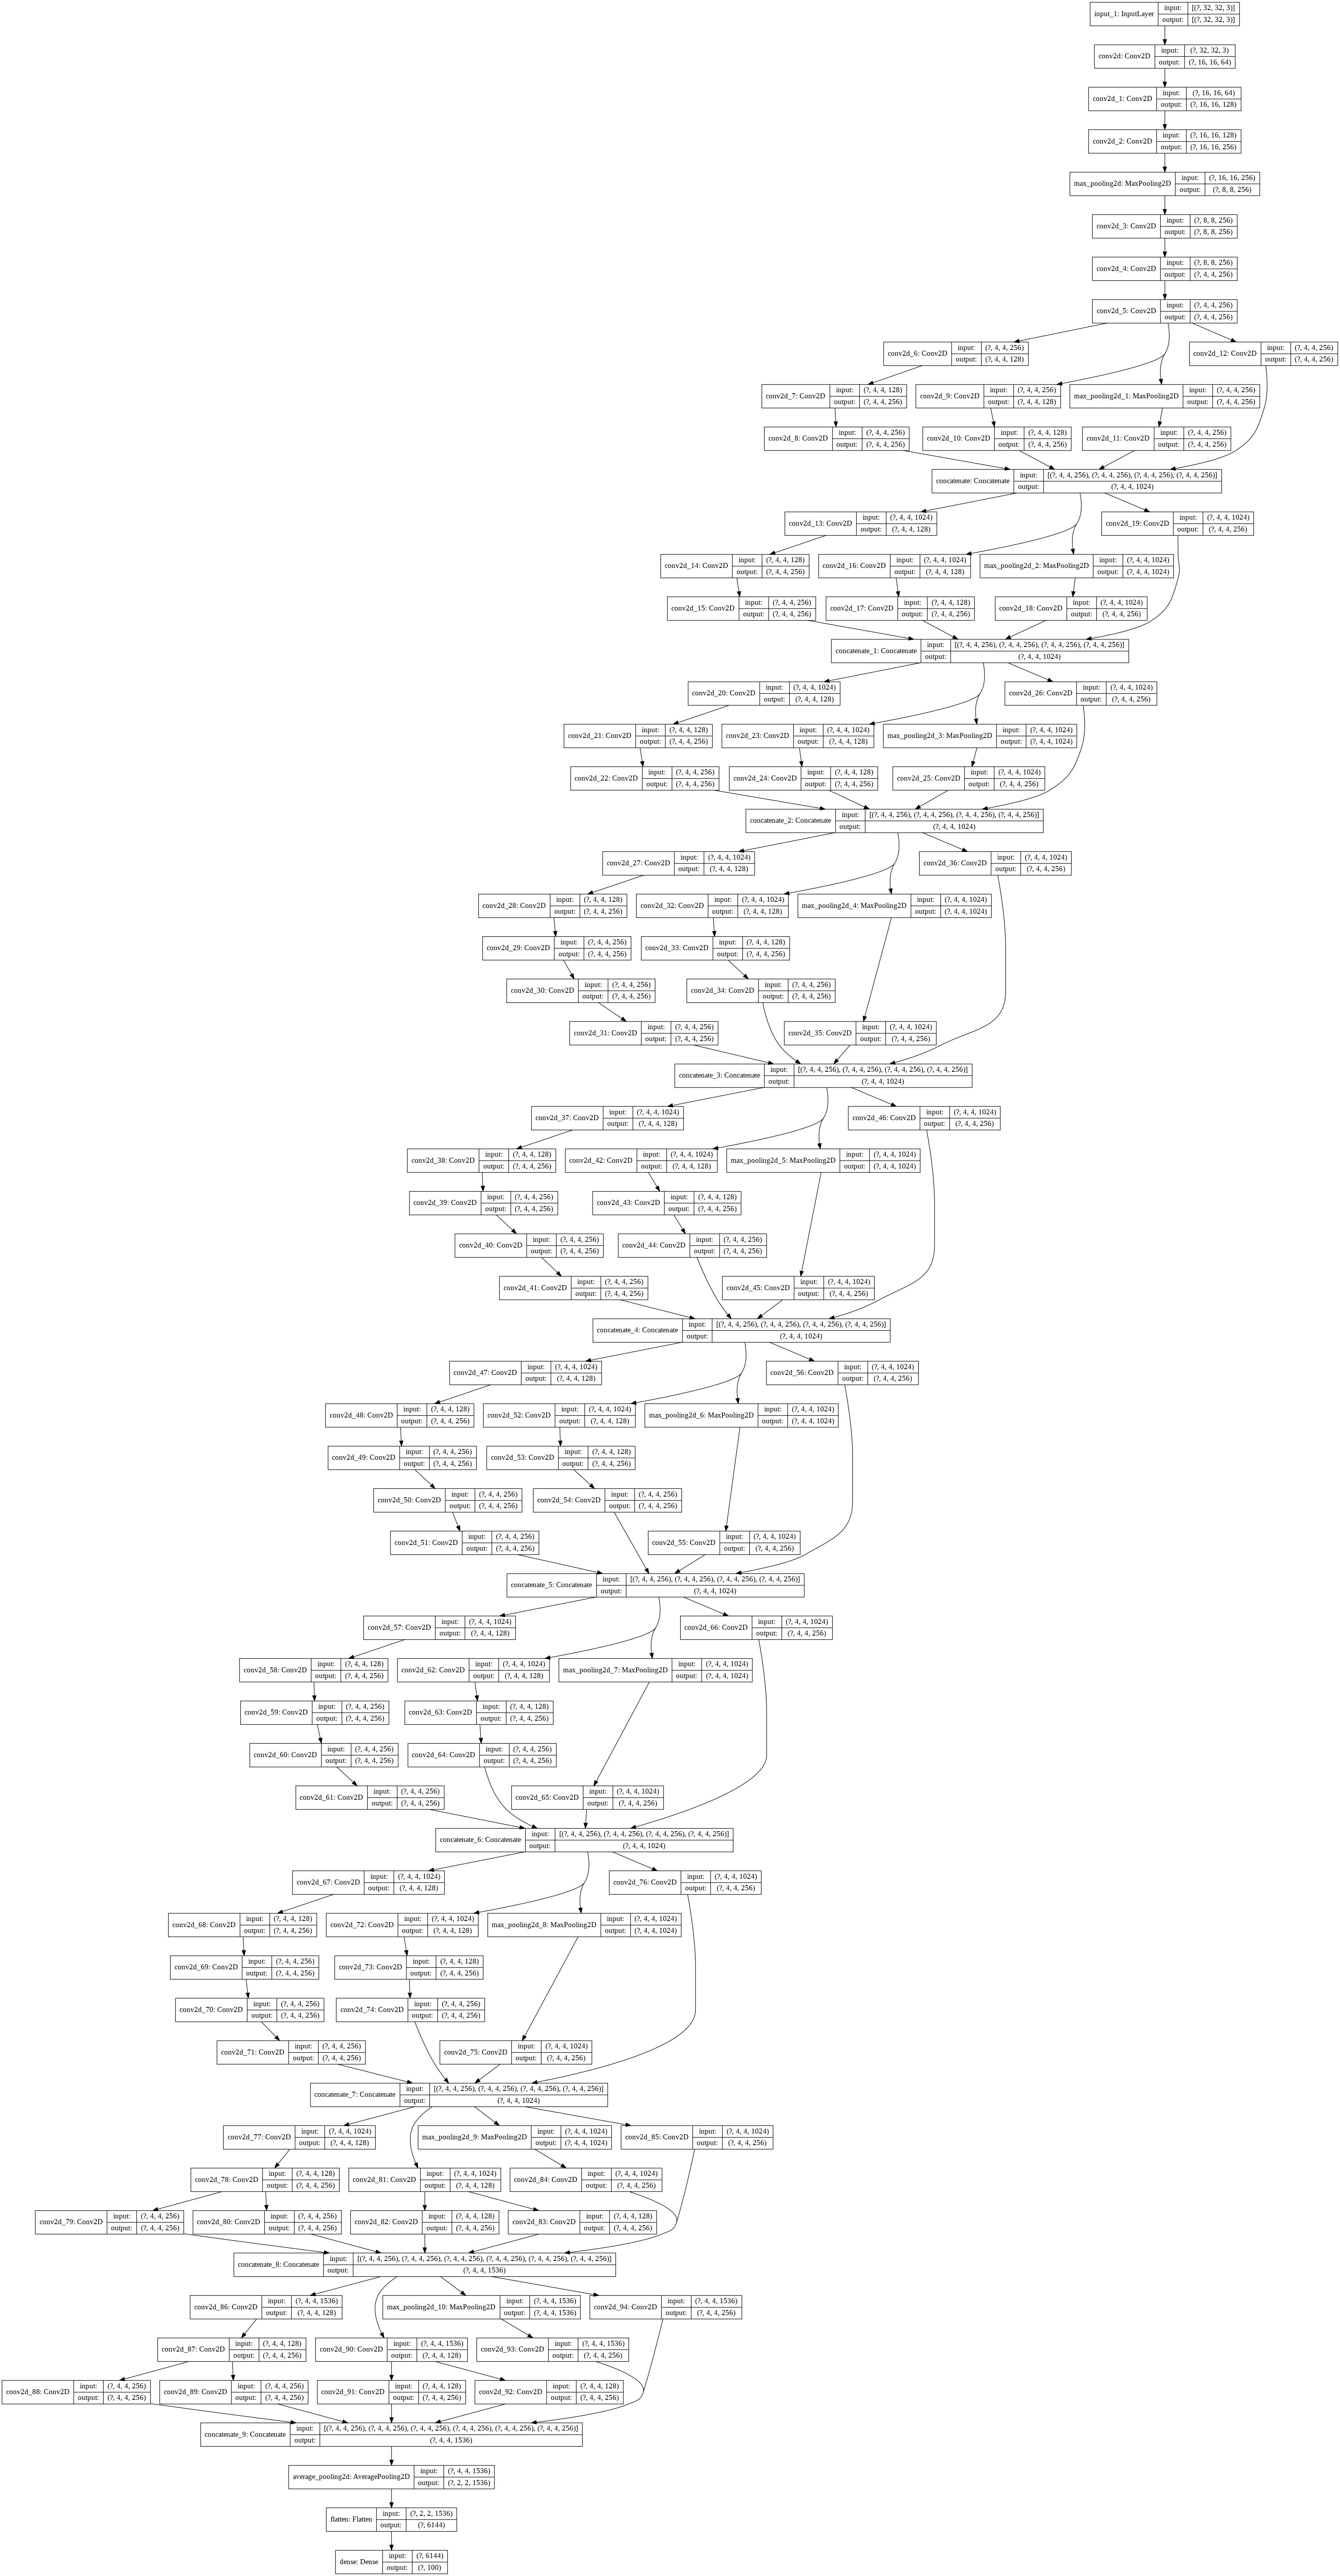

In [ ]:
from keras.utils import plot_model

plot_model(model, show_shapes = True, to_file = 'InceptionV2.png')

In [ ]:
datagen = ImageDataGenerator(
            rotation_range = 15,
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            horizontal_flip = True)
datagen.fit(x_train)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size = 128
checkpoint = ModelCheckpoint("InceptionV2_ADAM_NoRegularization.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto')
early = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 20, verbose = 1, mode = 'auto')
hist = model.fit_generator(steps_per_epoch = x_train.shape[0] // batch_size, generator = datagen.flow(x_train, y_train1, batch_size = batch_size), validation_data = (x_val, y_val1), validation_steps = 10,epochs = 200,callbacks = [checkpoint, early])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
390/390 [==============================] - ETA: 0s - loss: 4.6045 - accuracy: 0.0093WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0092s vs `on_test_batch_end` time: 0.1175s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.01320, saving model to InceptionV2_ADAM_NoRegularization.h5
390/390 [==============================] - 50s 127ms/step - loss: 4.6045 - accuracy: 0.0093 - val_loss: 4.5837 - val_accuracy: 0.0132
Epoch 2/200
390/390 [==============================] - ETA: 0s - loss: 4.2667 - accuracy: 0.0327
Epoch 00002: val_accuracy improved from 0.01320 to 0.04740, saving model to InceptionV2_ADAM_NoRegularization.h5
390/390 [==============================] - 47s 122ms/step - loss: 4.2667 - accuracy: 0.0327 - val_loss: 4.1032 - val_accuracy: 0.0474
Epoch 3/200
390/390 [==============================] - ETA: 0s - l

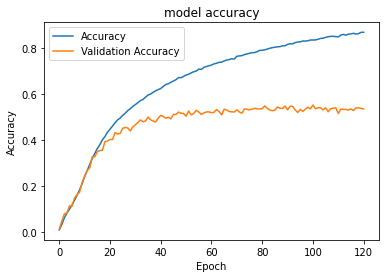

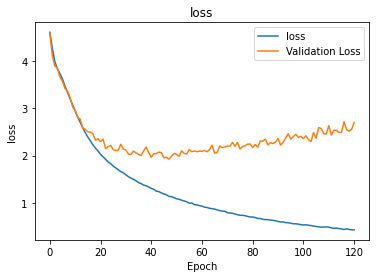

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.savefig('inception_adam_acc.png')
plt.show()

plt.figure(2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("loss")
plt.ylabel("loss")        
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.savefig('inception_adam_loss.png')
plt.show()


### Evaluation of Model

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.datasets import cifar100
import numpy as np
import keras

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

def normalize(x):
    mean = np.mean(x, axis = (0, 1, 2, 3))
    std = np.std(x, axis = (0, 1, 2, 3))
    print(mean)
    print(std)
    x = (x - mean) / std
    return x

x_train = normalize(x_train)
x_test = normalize(x_test)

y_train1 = keras.utils.to_categorical(y_train, 100)
y_test1 = keras.utils.to_categorical(y_test, 100)

169009152/169001437 [==============================] - 13s 0us/step
121.93584
68.38902
122.241035
68.63058


In [3]:
from keras.models import load_model
import os

path = os.path.join(os.path.dirname(os.getcwd()), "weights\InceptionV2_ADAM_NoRegularization.h5")
# path = '/content/drive/My Drive/weights/InceptionV2_ADAM_NoRegularization.h5'
print(path)
model1 = load_model(path)

/content/drive/My Drive/weights/InceptionV2_ADAM_NoRegularization.h5


In [4]:
_, accuracy = model1.evaluate(x_test, y_test1)

313/313 [==============================] - 8s 26ms/step - loss: 2.3038 - accuracy: 0.5557


In [5]:
pred = model1.predict(x_test)
pred = [np.argmax(x) for x in pred]

In [6]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(pred, y_test)
cr = classification_report(pred, y_test)

In [7]:
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.68      0.75       124
           1       0.67      0.73      0.70        92
           2       0.39      0.49      0.43        80
           3       0.36      0.31      0.33       116
           4       0.42      0.29      0.34       147
           5       0.63      0.59      0.61       107
           6       0.60      0.68      0.64        88
           7       0.52      0.69      0.59        75
           8       0.72      0.61      0.66       118
           9       0.68      0.73      0.70        93
          10       0.36      0.31      0.33       118
          11       0.46      0.38      0.41       122
          12       0.66      0.54      0.59       122
          13       0.56      0.54      0.55       103
          14       0.44      0.41      0.43       107
          15       0.39      0.57      0.46        69
          16       0.61      0.53      0.56       116
          17       0.78    

In [8]:
np.set_printoptions(threshold = np.inf)
cm

array([[84,  0,  0,  0,  0,  1,  0,  0,  0,  1,  4,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  5,  1,  0,  0,  8,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,
         0,  0,  0,  0],
       [ 0, 67,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,
         0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         2,  0,  1,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  5,  1,  1,  0,  0,
         0,  0,  0,  0],
       [ 0,  0, 39,  1,  0,  0,  0,  0,  1,  0,  1, 11,  0,  0,  0,  0,
         0,  0